In [62]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [64]:
import nntools as nt

In [65]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.MSE = nn.MSELoss()
    def criterion(self, y, d):
        return self.MSE(y, d)

In [98]:
vgg = tv.models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/xdg-cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 269MB/s] 


In [99]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [128]:
# Define the network with transfer learning

class VGG19Transfer(NNClassifier):
    def __init__(self, fine_tuning=False): #want to keep existing weights/biases
        super(VGG19Transfer, self).__init__()
        vgg = tv.models.vgg19(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        
        # Only maintain the feature space    
        self.net = nn.ModuleList()
        self.net = vgg.features
        # Change MaxPool to AvgPool
        self.net[4] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[9] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[18] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[27] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[36] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
 
    def forward(self, x):
        
        #FIX!
        rep = {}
#         features = [self.vgg[:4](x)] + [self.vgg[:7](x)] + [self.vgg[:12](x)] + [self.vgg[:21](x)] + [self.vgg[:30](x)]
#       
        #Conv2d
        rep['1_1'] = self.net[0:2](x)
        
        a = self.net[2:6](rep['1_1'])
        rep['2_1'] = self.net[6](a)
        
        a = self.net[7:11](rep['2_1'])
        rep['3_1'] = self.net[11](a)
        
        a = self.net[12:20](rep['3_1'])
        rep['4_1'] = self.net[20](a)
        
        a = self.net[21:22](rep['4_1'])
        rep['4_2'] = self.net[22](a)
        
        a = self.net[23:29](rep['4_2'])
        rep['5_1'] = self.net[29](a)

##relus
#         a = self.net[0:1](x)
#         rep['1_1'] = self.net[2](a)
        
#         a = self.net[3:8](rep['1_1'])
#         rep['2_1'] = self.net[9](a)
        
#         a = self.net[10:15](rep['2_1'])
#         rep['3_1'] = self.net[16](a)
        
#         a = self.net[17:28](rep['3_1'])
#         rep['4_1'] = self.net[29](a)
        
#         a = self.net[30:31](rep['4_1'])
#         rep['4_2'] = self.net[32](a)
        
#         a = self.net[33:44](rep['4_2'])
#         rep['5_1'] = self.net[45](a)

        return rep #dictionary data structure; can change if you guys have better ideas

In [101]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [70]:
# net = VGG19Transfer()

# print(net)

In [71]:
# get images
transform = tv.transforms.Compose([
#     tv.transforms.Resize((500, 500)), #whatever size we want i guess?
    tv.transforms.ToTensor(),
#             tv.transforms.Normalize((0,0,0),(1,1,1)),
    tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5)) #given range [0,1] for all channels
    ])

photo_path = 'photo.jpg'
photo = Image.open(photo_path)
p = transform(photo)
p = p[None,:,:,:]

art_path = 'art.jpg'
art = Image.open(art_path)
a = transform(art)
a = a[None,:,:,:]

x = torch.randn(3,500,500,requires_grad=True) # to allow updates!!
x = x[None,:,:,:]

In [72]:
x.shape

torch.Size([1, 3, 500, 500])

In [73]:
# get feature representations of artwork and photograph
# v = VGG19Transfer()
# P = v.forward(p)
# A = v.forward(a)

In [74]:
# A = v.forward(a)

In [75]:
# A['5_1'].shape

In [76]:
# Photograph feature response reshaped matrix (capital P^l)
# P1 = P['1'].view(64,-1)
# P2 = P['2'].view(128,-1)
# P3 = P['3'].view(256,-1)
# P4 = P['4'].view(512,-1)
# P5 = P['5'].view(512,-1)

In [77]:
# Artwork feature response reshaped matrix (capital A^l)
# A1 = A['1'].view(64,-1)
# A2 = A['2'].view(128,-1)
# A3 = A['3'].view(256,-1)
# A4 = A['4'].view(512,-1)
# A5 = A['5'].view(512,-1)

In [78]:
def Gram(featresp):
    return torch.mm(featresp,featresp.t()) # NlxNl (from paper)

In [112]:
def bruh(photo,art,net,epochs,lr=.01):
    
    h = photo.shape[2]
    w = photo.shape[3]
    x = torch.randn(1,3,h,w,requires_grad=True,device='cuda')  
    
    optimizer = torch.optim.Adam([x], lr=lr)
    
    P = net.forward(photo)
    P42NL = P['4_2'].shape[1]
    P42 = P['4_2'].view(P42NL,-1)

    
    A = net.forward(art) 
    A1 = A['1_1'].view(64,-1)
    A2 = A['2_1'].view(128,-1)
    A3 = A['3_1'].view(256,-1)
    A4 = A['4_1'].view(512,-1)
    A5 = A['5_1'].view(512,-1)
    
    
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        outputs = net.forward(x)
        
        out42 = outputs['4_2'].view(P42NL, -1)
        
        out1 = outputs['1_1'].view(64,-1)
        out2 = outputs['2_1'].view(128,-1)
        out3 = outputs['3_1'].view(256,-1)
        out4 = outputs['4_1'].view(512,-1)
        out5 = outputs['5_1'].view(512,-1)

        #get content loss
        #define criterion
        contentloss = ((out42-P42)**2).sum() / 2
        
        #get style gram matrices
        gram1 = Gram(out1)
        gram2 = Gram(out2)
        gram3 = Gram(out3)
        gram4 = Gram(out4)
        gram5 = Gram(out5)
        
        gram1o = Gram(A1)
        gram2o = Gram(A2)
        gram3o = Gram(A3)
        gram4o = Gram(A4)
        gram5o = Gram(A5)
        
#         #style loss
        E1 = 1/(4*(out1.shape[0])**2*(out1.shape[1])**2) * ((gram1-gram1o)**2).sum() #net.criterion(gram1,gram1o)
        E2 = 1/(4*(out2.shape[0])**2*(out2.shape[1])**2) * ((gram2-gram2o)**2).sum() #net.criterion(gram2,gram2o)
        E3 = 1/(4*(out3.shape[0])**2*(out3.shape[1])**2) * ((gram3-gram3o)**2).sum() #net.criterion(gram3,gram3o)
        E4 = 1/(4*(out4.shape[0])**2*(out4.shape[1])**2) * ((gram4-gram4o)**2).sum() #net.criterion(gram4,gram4o)
        E5 = 1/(4*(out5.shape[0])**2*(out5.shape[1])**2) * ((gram5-gram5o)**2).sum() #net.criterion(gram5,gram5o)
        
        #total style loss
        styleloss = (E1+E2+E3+E4+E5)/5
        
        #get total loss
        loss = contentloss + 1000*styleloss
        
        #backprop
        loss.backward(retain_graph=True)
        
        #parameter search
        optimizer.step()
        if epoch % 25 == 0:
            print(loss)
            print(epoch)

#         x[0,0,0:250,0:250] = 1
    return x

In [124]:
# get images
transform = tv.transforms.Compose([
#     tv.transforms.Resize((500, 500)), #whatever size we want i guess?
    tv.transforms.ToTensor(),
#             tv.transforms.Normalize((0,0,0),(1,1,1)),
    tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5)) #given range [0,1] for all channels
    ])

photo_path = 'photo.jpg'
photo = Image.open(photo_path)
p = transform(photo)
p = p[None,:,:,:]

art_path = 'art.jpg'
art = Image.open(art_path)
a = transform(art)
a = a[None,:,:,:]

# x = torch.randn(3,500,500,requires_grad=True) # to allow updates!!
# x = x[None,:,:,:]

In [129]:
p = p.to(device)
a = a.to(device)
v = VGG19Transfer().to(device)

In [130]:
aa = bruh(p,a,v,5000)

tensor(89354.5781, device='cuda:0', grad_fn=<AddBackward0>)
0
tensor(59752.0820, device='cuda:0', grad_fn=<AddBackward0>)
25
tensor(40405.5234, device='cuda:0', grad_fn=<AddBackward0>)
50
tensor(26268.0352, device='cuda:0', grad_fn=<AddBackward0>)
75
tensor(18367.6758, device='cuda:0', grad_fn=<AddBackward0>)
100
tensor(13800.2676, device='cuda:0', grad_fn=<AddBackward0>)
125
tensor(10770.0361, device='cuda:0', grad_fn=<AddBackward0>)
150
tensor(8729.2217, device='cuda:0', grad_fn=<AddBackward0>)
175
tensor(7221.1958, device='cuda:0', grad_fn=<AddBackward0>)
200
tensor(6087.7075, device='cuda:0', grad_fn=<AddBackward0>)
225
tensor(5242.3960, device='cuda:0', grad_fn=<AddBackward0>)
250
tensor(4594.8975, device='cuda:0', grad_fn=<AddBackward0>)
275
tensor(4090.7397, device='cuda:0', grad_fn=<AddBackward0>)
300
tensor(3685.4812, device='cuda:0', grad_fn=<AddBackward0>)
325
tensor(3353.5842, device='cuda:0', grad_fn=<AddBackward0>)
350
tensor(3083.8889, device='cuda:0', grad_fn=<AddBackwa

<IPython.core.display.Javascript object>


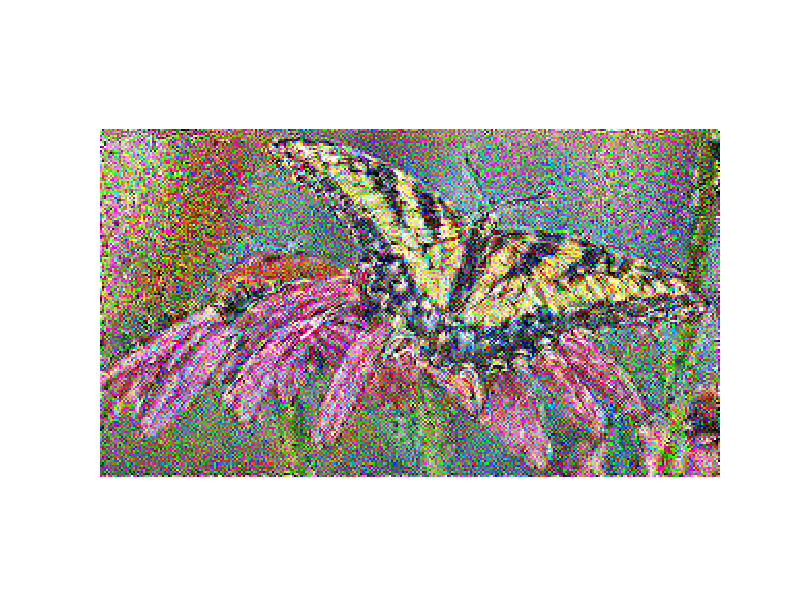

In [131]:
aaa = (aa.detach().cpu())
h = aa.shape[2]
aaa = aaa.view(3,h,-1)
myimshow(aaa)



<IPython.core.display.Javascript object>


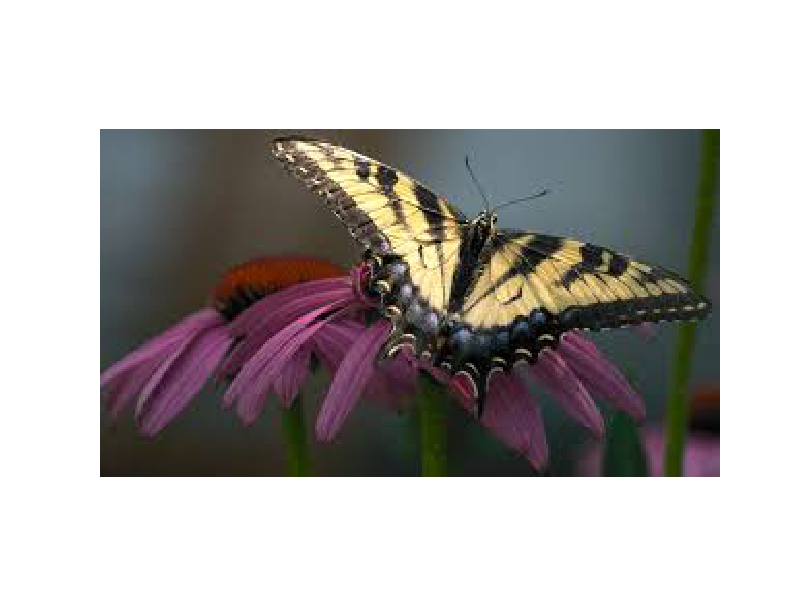

In [56]:
myimshow(p.view(3,h,-1))

<IPython.core.display.Javascript object>


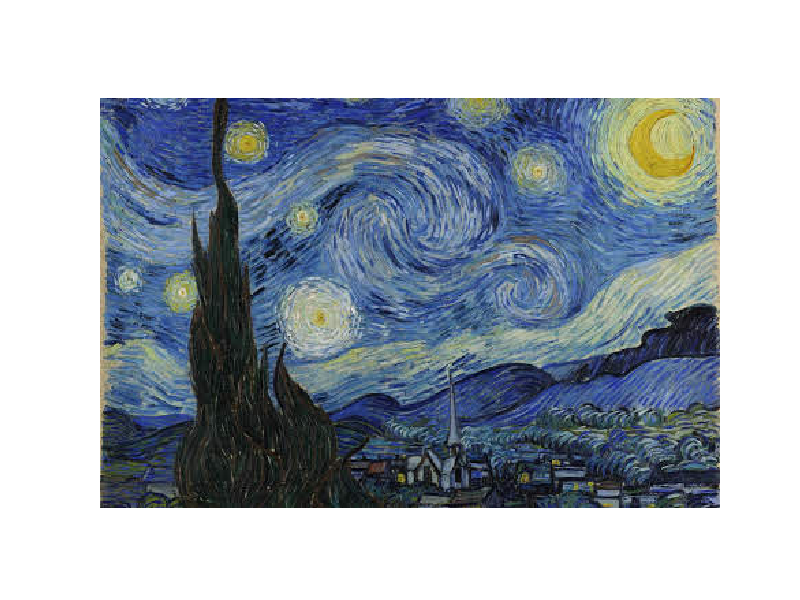

In [55]:
hh = a.shape[2]
myimshow(a.view(3,hh,-1))

In [ ]:
plt.subplot(1, 2, 1)
myimshow(p.view(3,h,-1))
plt.subplot(1, 2, 2)
hh = a.shape[2]
myimshow(a.view(3,hh,-1))

In [ ]:
imgplot = plt.imshow(aaa.moveaxis([0,1,2],[1,2,0]))

In [ ]:
import glob
from PIL import Image

images=glob.glob("/root/data/amz//train_small/*jpg")
for image in images:
img = Image.open(image)
trans = transforms.ToPILImage()
trans1 = transforms.ToTensor()
plt.imshow(trans(trans1(img)))

In [ ]:
# a = v.parameters()
# list(a)
# print(list(v.parameters()))
v = VGG19Transfer(x)

In [ ]:
#test visualization of feature representation
b = P['1']
bb = b[0,0,:,:].detach() #2nd axis is different feature map of layer defined above as b = g['layernumber']
bb.numpy()
plt.imshow(bb.numpy()) # look at the feature map!